In [30]:
import pandas as pd
import numpy as np
import os
import PIL
from pathlib import Path
from PIL import Image
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import IPython
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix
        

In [2]:

root_path = Path().resolve()
img = Image.open(f'{root_path}/data/training/aeroplane/2007_000033.jpg')
print(img.size)
# img
maxPixel = 128
imScalled = img.resize((maxPixel,maxPixel))
img_pixel = np.reshape(list(imScalled.getdata()),(maxPixel,maxPixel,3))
img_pixel
print(img_pixel.size)

(500, 366)
49152


In [3]:
maxPixel=299
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

# train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'data/training'),  batch_size=20, class_mode = 'binary', target_size = (img.size[0], img.size[1]),classes=['others', 'aeroplane'])
# valid_generator = valid_datagen.flow_from_directory(os.path.join(root_path, 'data/validation'),  batch_size=20, class_mode = 'binary', target_size = (img.size[0], img.size[1]),classes=['others','aeroplane'])

train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'data/training'),  batch_size=20, class_mode = 'binary', target_size = (maxPixel, maxPixel),classes=['others', 'aeroplane'])
valid_generator = valid_datagen.flow_from_directory(os.path.join(root_path, 'data/validation'),  batch_size=20, class_mode = 'binary', target_size = (maxPixel, maxPixel),classes=['others', 'aeroplane'])

# base_model = InceptionV3(input_shape = (img.size[0], img.size[1], 3), include_top = True, weights = 'imagenet', classes=1000)
base_model = InceptionV3(
    input_shape = (maxPixel, maxPixel, 3),
    include_top = True,
    weights = 'imagenet',
    classes=1000,
)

for layer in base_model.layers:
    layer.trainable = False


Found 83 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


2022-09-04 16:56:18.267668: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-09-04 16:56:18.298775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 16:56:18.299857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 980M computeCapability: 5.2
coreClock: 1.1265GHz coreCount: 12 deviceMemorySize: 7.94GiB deviceMemoryBandwidth: 149.31GiB/s
2022-09-04 16:56:18.299958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/inc

In [4]:
base_model.output

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

In [5]:
x = Flatten()(base_model.output)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(1000, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)
x = Flatten()(model.output)
model = tf.keras.models.Model(model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [6]:
print(Flatten()(model.output))
500*366*3

KerasTensor(type_spec=TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None), name='flatten_2/Reshape:0', description="created by layer 'flatten_2'")


549000

In [7]:
model.output

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'flatten_1')>

In [8]:
# Fit the model
plane_detector = model.fit(
    train_generator, 
    validation_data=valid_generator, 
    steps_per_epoch=1,
#     validation_steps=valid_generator.samples/valid_generator.batch_size,
    epochs=10
)

2022-09-04 16:56:24.566441: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-04 16:56:24.585170: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 3.4544 - acc: 0.0000e+00 - val_loss: 1.1271 - val_acc: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 2.7637 - acc: 0.0000e+00 - val_loss: 1.1271 - val_acc: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 6s 6s/step - loss: 3.4544 - acc: 0.0000e+00 - val_loss: 1.1271 - val_acc: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 6s 6s/step - loss: 3.1090 - acc: 0.0000e+00 - val_loss: 1.1271 - val_acc: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 3.4544 - acc: 0.0000e+00 - val_loss: 1.1271 - val_acc: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 2.7637 - acc: 0.0000e+00 - val_loss: 1.1271 - val_acc: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 2.4183 - acc: 0.0000e+00 - val_loss: 1.1271 - val_acc: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 6s 

In [9]:
def get_features(
    data_generator: str,
    feature_dimension: float = 1000.,
    sample_size: int = 83,
    batch_size: int = 200
):
    features = np.zeros(shape=(sample_size, feature_dimension))  # Must be equal to the output of the model
    labels = np.zeros(shape=(sample_size))
    
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in data_generator:
        features_batch = model.predict(inputs_batch)
#         print(features_batch.shape)
        if features_batch.shape[0] != batch_size:
            features[i * batch_size:] = features_batch
            labels[i * batch_size:] = labels_batch
        else:
            features[i * batch_size: (i + 1) * batch_size] = features_batch
            labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_size:
            break
    
    return features, labels 

In [10]:
# Get train features
train_features, train_labels = get_features(
    data_generator=train_generator,
    feature_dimension=1000,
    sample_size=83,
    batch_size=20
)

In [11]:
# Get validation features
validation_features, validation_labels = get_features(
    data_generator=valid_generator,
    feature_dimension=1000,
    sample_size=92,
    batch_size=20
)

In [12]:
np.unique(train_labels, return_counts=True)

(array([0., 1.]), array([50, 33]))

In [13]:
i = 0
for inputs_batch, labels_batch in valid_generator:
    i += 1
    print(model.evaluate(inputs_batch, labels_batch))
    if i >= 1:
        break

1/1 [==============================] - 2s 2s/step - loss: 1.3823 - acc: 0.0000e+00
[1.3823413848876953, 0.0]


### Train SVM

In [14]:
# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(train_features)
X_test = sc.transform(validation_features)

In [15]:
train_labels

array([0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.])

In [16]:
svm_classifier = SVC(kernel = 'rbf', random_state = 0)
svm_classifier.fit(X_train, train_labels)

SVC(random_state=0)

In [17]:
np.unique(train_labels, return_counts=True)

(array([0., 1.]), array([50, 33]))

In [18]:
np.unique(validation_labels, return_counts=True)

(array([0., 1.]), array([77, 15]))

In [26]:
# Prediction
y_pred = svm_classifier.predict(X_test) 
y_pred

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [36]:
conf_matrix = confusion_matrix(validation_labels, y_pred)

In [37]:
conf_matrix

array([[77,  0],
       [ 1, 14]])

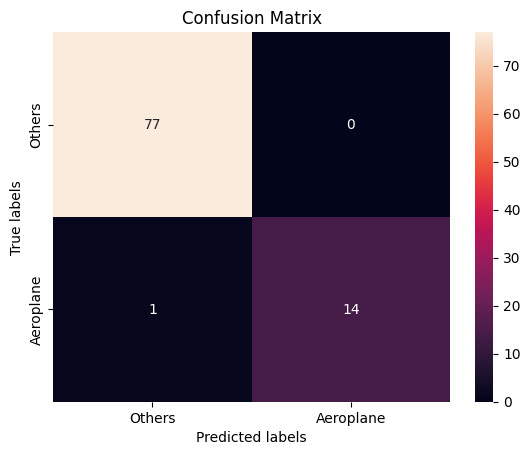

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='g',
    ax=ax
)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Others', 'Aeroplane']); ax.yaxis.set_ticklabels(['Others', 'Aeroplane']);